# Model training
In this notebook a model is created, trained and evaluated on the test set.
<br>MLFlow is used to track the experiments and push a model to production.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import mlflow

from countryguess.data import Dataset, TestDataset
from countryguess.model import CustomEmbeddingModel, EfficientNetEmbedding, TripletModel
from countryguess.generate import TripletDataset, ValDataset
from countryguess.training import train, evaluate

## Plotting datasets

### Initialise datasets

In [2]:
shape=(160, 160)
ref_data = Dataset(shape=shape)
train_data = TripletDataset(shape=shape, temp=0.9)
val_data = ValDataset(shape=shape, temp=0.9)
test_data = TestDataset(shape=shape)

### Plotting

#### Training data

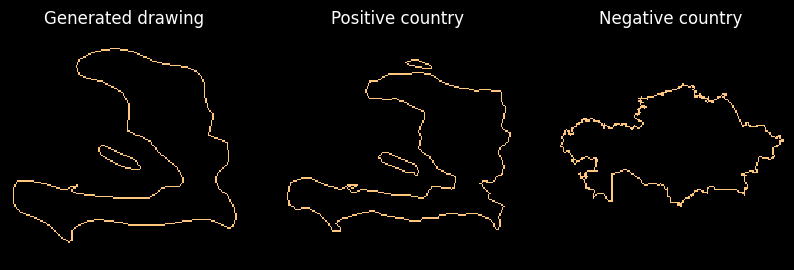

In [3]:
idx = random.randint(0, len(train_data) - 1)
sample = train_data[idx]

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
fig.patch.set_facecolor("black")
axs[0].imshow(sample["drawing"], interpolation="nearest", origin="lower", cmap="copper")
axs[0].set_title("Generated drawing", color="white")
axs[1].imshow(sample["pos_img"], interpolation="nearest", origin="lower", cmap="copper")
axs[1].set_title("Positive country", color="white")
axs[2].imshow(sample["neg_img"], interpolation="nearest", origin="lower", cmap="copper")
axs[2].set_title("Negative country", color="white")
for ax in axs:
    ax.axis("off")
plt.show()

#### Validation set

In [4]:
from countryguess.data import poly_to_img

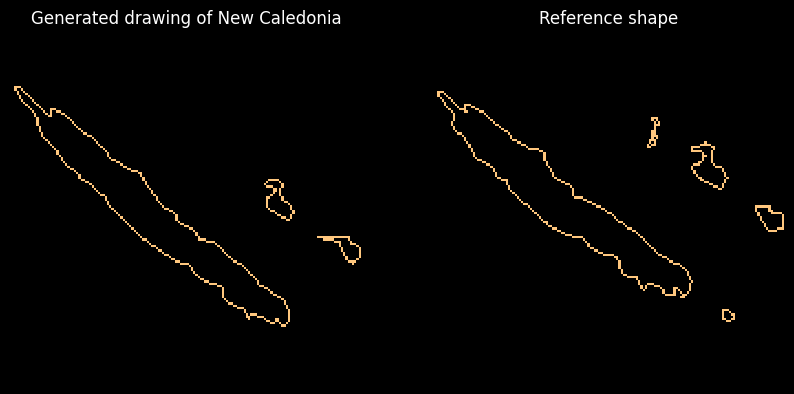

In [5]:
idx = random.randint(0, len(val_data) - 1)
sample = val_data[idx]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.patch.set_facecolor("black")
axs[0].imshow(sample["drawing"], interpolation="nearest", origin="lower", cmap="copper")
axs[0].set_title(f"Generated drawing of {sample['country_name']}", color="white")

img = poly_to_img(ref_data.from_country_name(sample["country_name"]), ref_data.shape)
axs[1].imshow(img, interpolation="nearest", origin="lower", cmap="copper")
axs[1].set_title("Reference shape", color="white")
for ax in axs:
    ax.axis("off")
plt.show()

#### Test set (user drawings)

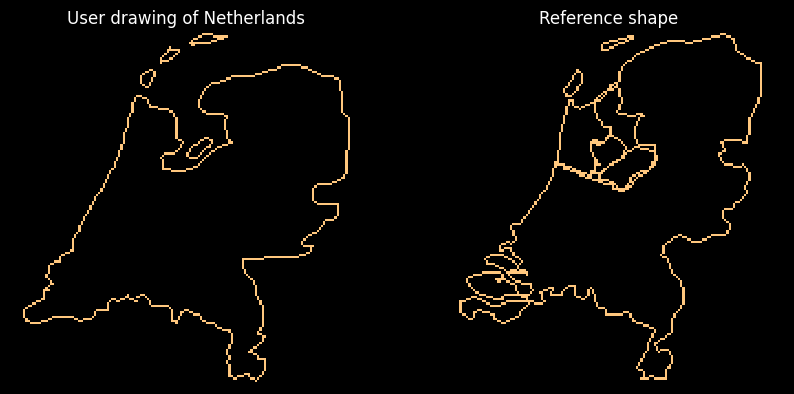

In [6]:
idx = random.randint(0, len(test_data) - 1)
sample = test_data[idx]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.patch.set_facecolor("black")
axs[0].imshow(sample["drawing"], interpolation="nearest", origin="lower", cmap="copper")
axs[0].set_title(f"User drawing of {sample['country_name']}", color="white")

img = poly_to_img(ref_data.from_country_name(sample["country_name"]), ref_data.shape)
axs[1].imshow(img, interpolation="nearest", origin="lower", cmap="copper")
axs[1].set_title("Reference shape", color="white")
for ax in axs:
    ax.axis("off")
plt.show()

## Training model

Run the following command to start the MLFlow Tracking UI: `mlflow ui --port 5001`
<br>Access the MLFlow Tracking UI at: http://127.0.0.1:5001

In [7]:
device = torch.device("mps")

In [8]:
mlflow.set_experiment("local")

params = {
    "channels": 12, #4 * random.randint(2, 6),
    "nr_conv_blocks": 4, #random.randint(2, 5),
    "embedding_size": 768, #128 * random.randint(1, 8),
    "shape": 96, #32 * random.randint(1, 4),
    # "pretrained": True,
    "learning_rate": random.uniform(0.006, 0.012),
    "margin": 0.8, #random.uniform(0.3, 1.2),
    "temperature": 0.6, #random.uniform(0.4, 1.1),
    "nr_epochs": 56, #random.randint(15, 75),
}

model = TripletModel(CustomEmbeddingModel(**params).to(device)).to(device)
# model = TripletModel(EfficientNetEmbedding(**params).to(device)).to(device)
params["embedding_model"] = model.embedding_model.__class__.__name__

optimizer = torch.optim.SGD(model.parameters(), lr=params["learning_rate"])
triplet_loss = nn.TripletMarginLoss(margin=params["margin"])

print(params)

{'channels': 12, 'nr_conv_blocks': 4, 'embedding_size': 768, 'shape': 96, 'learning_rate': 0.01180530190210679, 'margin': 0.8, 'temperature': 0.6, 'nr_epochs': 56, 'embedding_model': 'CustomEmbeddingModel'}


In [9]:
#Initialise datasets & dataloaders
ref_data = Dataset(shape=(params["shape"], params["shape"]))
train_data = TripletDataset(shape=(params["shape"], params["shape"]), temp=params["temperature"])
val_data = ValDataset(shape=(params["shape"], params["shape"]), temp=params["temperature"])

train_dl = DataLoader(train_data, batch_size=24, shuffle=True, num_workers=2)
val_dl = DataLoader(val_data, batch_size=24, num_workers=2)

In [ ]:
with mlflow.start_run() as run:
    mlflow.log_params(params)

    # Start training
    for epoch in range(params["nr_epochs"]):
        loss = train(model, train_dl, triplet_loss, optimizer)
        mlflow.log_metric("loss", loss, epoch)
        print(
            "Epoch: {}/{}\t loss: {:.3f}".format(epoch + 1, params["nr_epochs"], loss)
        )

        if (epoch + 1) % 5 == 0:
            _, ranking = evaluate(model, val_dl, ref_data)

            mlflow.log_metric("val_avg_rank", np.mean(ranking) + 1, epoch)
            mlflow.log_metric("val_top_10_acc", np.mean(ranking < 10), epoch)
            mlflow.log_metric("val_top_1_acc", np.mean(ranking < 1), epoch)

            print(
                "Epoch: {}/{}\t Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t".format(
                    epoch + 1,
                    params["nr_epochs"],
                    np.mean(ranking) + 1,
                    100 * np.mean(ranking < 10),
                    100 * np.mean(ranking < 1),
                )
            )

Epoch: 1/56	 loss: 0.058


Epoch: 2/56	 loss: 0.040


Epoch: 3/56	 loss: 0.025


Epoch: 4/56	 loss: 0.016


Epoch: 5/56	 loss: 0.010


Epoch: 5/56	 Average rank: 1.48	 top 10 acc: 98.0%	 top 1 acc: 89.8%	


Epoch: 6/56	 loss: 0.004


Epoch: 7/56	 loss: 0.009


Epoch: 8/56	 loss: 0.012


Epoch: 9/56	 loss: 0.013


Epoch: 10/56	 loss: 0.002


Epoch: 10/56	 Average rank: 2.19	 top 10 acc: 98.5%	 top 1 acc: 85.3%	


Epoch: 11/56	 loss: 0.015


Epoch: 12/56	 loss: 0.002


Epoch: 13/56	 loss: 0.019


Epoch: 14/56	 loss: 0.020


Epoch: 15/56	 loss: 0.011


Epoch: 15/56	 Average rank: 1.47	 top 10 acc: 98.5%	 top 1 acc: 91.4%	


Epoch: 16/56	 loss: 0.001


Epoch: 17/56	 loss: 0.000


Epoch: 18/56	 loss: 0.004


Epoch: 19/56	 loss: 0.028


Epoch: 20/56	 loss: 0.033


Epoch: 20/56	 Average rank: 1.46	 top 10 acc: 98.5%	 top 1 acc: 88.3%	


Epoch: 21/56	 loss: 0.010


Epoch: 22/56	 loss: 0.008


### Evaluate model

In [ ]:
test_data = TestDataset(shape=(params["shape"], params["shape"]))
test_dl = DataLoader(test_data, batch_size=32)

In [ ]:
country_names, ranking = evaluate(model, test_dl, ref_data)

with mlflow.start_run(run_id=run.info.run_id):
    mlflow.log_metric("nr_test_samples", len(test_data))
    mlflow.log_metric("test_avg_rank", np.mean(ranking) + 1)
    mlflow.log_metric("test_top_10_acc", np.mean(ranking < 10))
    mlflow.log_metric("test_top_1_acc", np.mean(ranking < 1))

In [ ]:
print("Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t"
      .format(np.mean(ranking) + 1, 100 * np.mean(ranking < 10), 100 * np.mean(ranking < 1)))

In [ ]:
fig = plt.figure(figsize = (14, 6))
plt.bar(country_names, ranking)
plt.xticks(rotation=90)
plt.ylim((0, 10))
plt.ylabel("Rank")
plt.show()

### Log model

In [ ]:
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.pytorch.log_model(model, "model")

Make sure to set promote your desired model to the Model Registry using the MLFlow UI. The model with the champion alias will be used by the ML server.  You can set the name of the model within the docker-compose.yml file or by setting the environment variable MODEL_NAME if you run the app locally.

### Error Analysis
Let's look at the countries for which the model struggles. 

In [ ]:
print("Rank\tCountry")
for country, rank, in zip(country_names, ranking):
    if rank > 0:
        print(f"{int(rank+1)}\t{country}")